In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [16]:
df = pd.read_csv('./data/dataset_romance.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
28197,no se respondio no se respondio no se respondio,Spanish
27821,no habra salido no habra salido no habra salido,Spanish
28960,callate susurro callate susurro callate,Spanish
7064,ove il sole ove il sole ove il sole ove il sole,Italian
11148,dentro il convento dentro il convento dentro il,Italian


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [17]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Input dimension: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Input dimension: 48
Rows: 29575
Amount of languages to identify: 5


In [18]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(8, activation='relu')
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=125, batch_size=2048,verbose=1)

Epoch 1/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.2027 - loss: 2.3461 - val_accuracy: 0.1924 - val_loss: 1.6076
Epoch 2/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.2008 - loss: 1.6112 - val_accuracy: 0.2215 - val_loss: 1.6005
Epoch 3/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.2186 - loss: 1.6015 - val_accuracy: 0.2299 - val_loss: 1.5958
Epoch 4/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2449 - loss: 1.5948 - val_accuracy: 0.2685 - val_loss: 1.5875
Epoch 5/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2614 - loss: 1.5871 - val_accuracy: 0.2874 - val_loss: 1.5756
Epoch 6/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2866 - loss: 1.5733 - val_accuracy: 0.3114 - val_loss: 1.5569
Epoch 7/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.3052 - loss: 1.5538 - val_accuracy: 0.3385 - val_loss: 1.5209
Epoch 8/125
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.3279 - loss: 1.5189 - val_accu

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

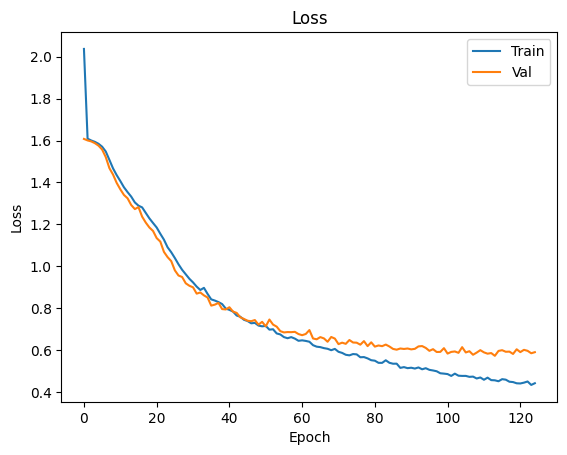

In [25]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

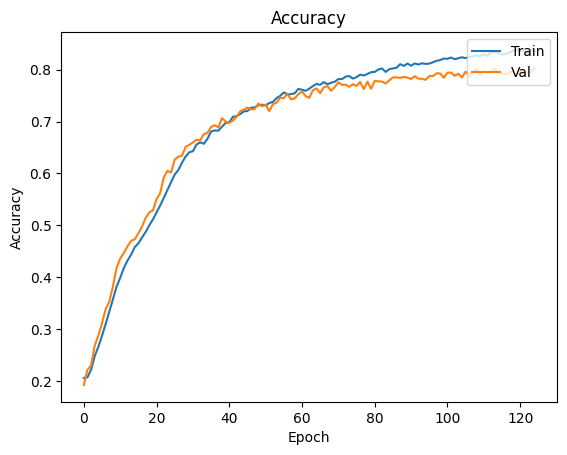

In [26]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [22]:
prediction_word = ""
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: 
Text after preprocessing:     
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Language_French: 0.0
Language_Italian: 45.5
Language_Latin: 0.0
Language_Portuguese: 54.5
Language_Spanish: 0.0


# Save model
Here a model can be loaded

In [23]:
model.save('./models/model_romance.keras')

# Load model
Here a model can be loaded

In [24]:
model = load_model('./models/model_romance.keras')